In [27]:
# Import lib:
import warnings                          # Warning control
warnings.filterwarnings('ignore')

import pandas as pd                     # Data loading & manipulation

import matplotlib.pyplot as plt         # Basic plotting
import matplotlib.dates as mdates       # Date formatting for plots
import matplotlib.ticker as mtick       # Axis tick formatting

import seaborn as sns                   # Statistical data visualization
sns.set_theme(style='whitegrid')       # Set seaborn theme

# Statsmodels plotting functions for time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pandas plotting utility
from pandas.plotting import lag_plot

# Plotly for interactive plots
import plotly.express as px              # Interactive plotting (simpler interface)
import plotly.graph_objects as go        # Advanced interactive plots
from plotly.subplots import make_subplots


In [28]:
# Load dataset into a pandas DataFrame
df = pd.read_csv('/home/boto-cdr/Área de trabalho/portfolio_github/deepseek-stock-market/dados_final.csv')

# Preview the first three rows to inspect initial data structure and values
df.head(3)

,Date,Close_AAPL,Close_AMZN,Close_GOOGL,Close_MSFT,Close_NVDA,High_AAPL,High_AMZN,High_GOOGL,High_MSFT,...,Volume_AAPL,Volume_AMZN,Volume_GOOGL,Volume_MSFT,Volume_NVDA,Change_AAPL,Change_AMZN,Change_GOOGL,Change_MSFT,Change_NVDA
0,2010-01-04,7.56,6.70,15.68,30.01,0.46,7.70,6.83,15.75,30.72,...,612150000.0,152010000,39160000,73090000,800350000,"-1,56%","-0,45%","1,10%","-1,90%","-2,13%"
1,2010-01-05,7.43,6.73,15.61,28.96,0.47,7.62,6.77,15.71,30.20,...,608150000.0,177130000,60160000,102000000,728700000,"-1,72%","0,45%","-0,45%","-3,50%","2,17%"
2,2010-01-06,7.06,6.61,15.22,29.32,0.47,7.41,6.74,15.66,29.66,...,881770000.0,143620000,79610000,63380000,649170000,"-4,98%","-1,78%","-2,50%","1,24%","0,00%"


# Model Training and Evaluation

Future prices of one stock only (e.g., NVDA close prices)              
➤ Use univariate forecasting models.

Future prices using all stocks together (e.g., predict NVDA using AAPL, GOOGL, etc.)
➤ Use multivariate regression models or multivariate time series models.


| Goal                                 | Technique                          | When to Use                                           | Pros                                     | Tools                   |
| ------------------------------------ | ---------------------------------- | ----------------------------------------------------- | ---------------------------------------- | ----------------------- |
| Simple and interpretable forecasting | **Prophet**                        | For business-friendly use cases, seasonal trends      | Easy to implement, good for business use | `fbprophet`             |
| Classic time series                  | **ARIMA/SARIMAX**                  | Univariate or exogenous variables (like news, events) | Good statistical control, explainable    | `statsmodels`           |
| Learn temporal dependencies          | **LSTM**                           | When patterns are complex and need memory (lags)      | Powerful, good for sequences             | `Keras / PyTorch`       |
| Multivariate prediction              | **Multivariate Linear Regression** | Predict one company using others                      | Easy, interpretable                      | `sklearn`               |
| Cutting-edge, attention-based        | **Transformer**                    | For high accuracy and large datasets                  | State-of-the-art, needs tuning           | `HuggingFace / PyTorch` |
| Outlier detection                    | **Isolation Forest**               | To identify anomalous data points                     | Effective for high-dimensional data      | `sklearn`               |
| Ensemble learning                    | **Random Forest**                  | When you need a robust model with multiple decision trees | Reduces overfitting, handles non-linear data | `sklearn`           |
| Regularized regression               | **Ridge Regression**               | For multivariate prediction while controlling overfitting | Prevents overfitting, interpretable      | `sklearn`               |
| Anomaly detection                    | **Isolation Forest**               | For detecting outliers in time series data            | Effective for detecting anomalies        | `sklearn`               |


## 1. ARIMA – Univariate Time Series Forecast (e.g., NVDA)


In [31]:
df.index = pd.to_datetime(df.index)


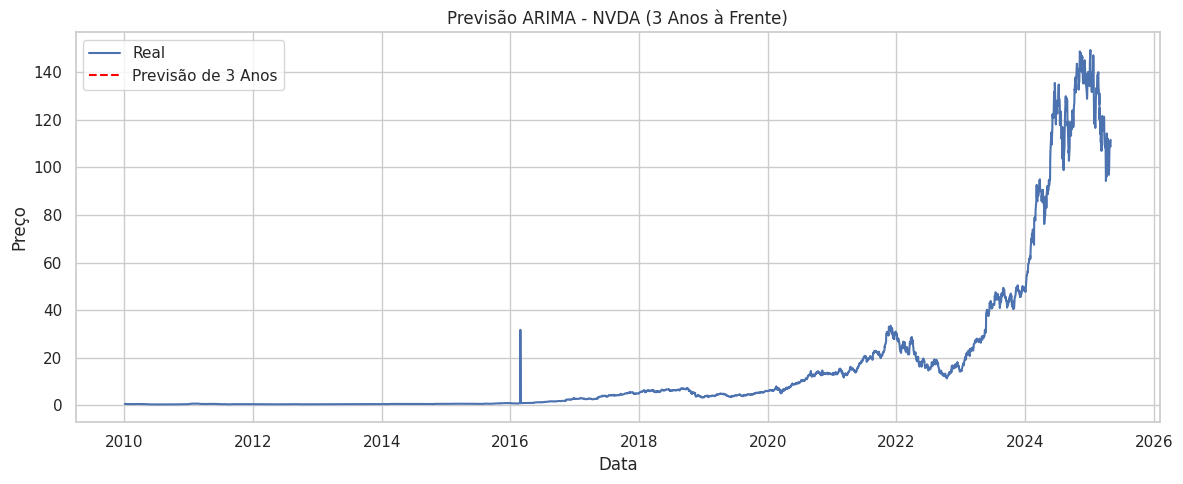

In [44]:
# Garantir que o índice já é datetime
df.index = pd.to_datetime(df.index)

# Selecionar a série de dados
series = df['Close_NVDA'].dropna()

# Ajuste do modelo ARIMA
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()

# Previsão para 3 anos (~252 dias úteis por ano)
steps = 252 * 3  # Total de 756 dias úteis
forecast = model_fit.forecast(steps=steps)

# Obter a última data do índice
last_date = series.index[-1]

# Criar o índice para a previsão
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq='B')

# Criar a série de previsão
forecast = pd.Series(forecast, index=forecast_index)

# Plotar o gráfico
plt.figure(figsize=(12, 5))
plt.plot(series, label='Real')
plt.plot(forecast, label='Previsão de 3 Anos', linestyle='--', color='red')
plt.title('Previsão ARIMA - NVDA (3 Anos à Frente)')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2: Analise de Outliers

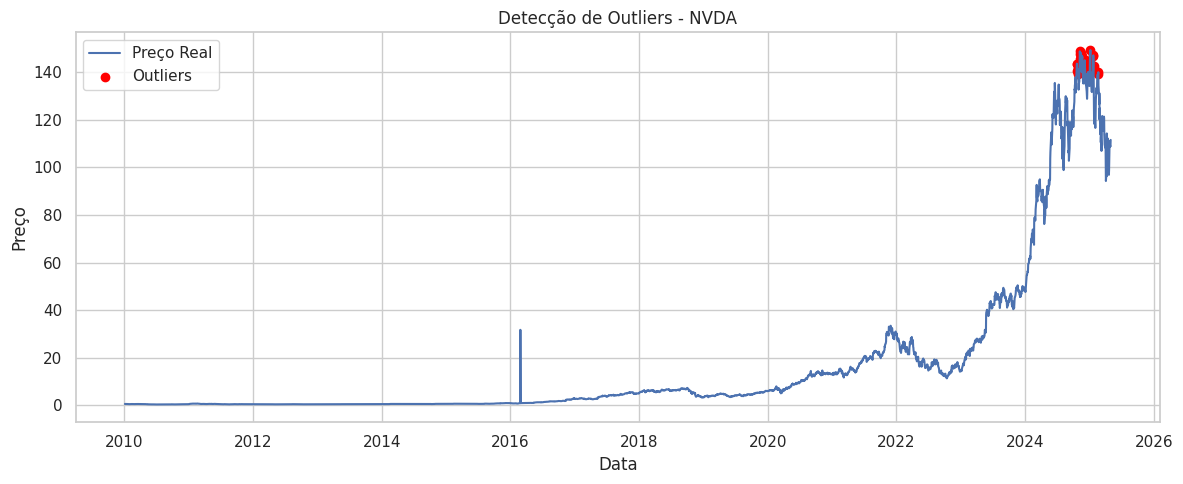

In [35]:
from sklearn.ensemble import IsolationForest

# Aplicar o modelo Isolation Forest para detecção de outliers
model_outliers = IsolationForest(contamination=0.01)  # Ajustar o nível de contaminação conforme necessário
outliers = model_outliers.fit_predict(df[['Close_NVDA']])

# Marcar outliers no gráfico
df['Outlier'] = outliers
plt.figure(figsize=(12, 5))
plt.plot(df['Close_NVDA'], label='Preço Real')
plt.scatter(df.index[df['Outlier'] == -1], df['Close_NVDA'][df['Outlier'] == -1], color='red', label='Outliers')
plt.title('Detecção de Outliers - NVDA')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3: Random Forest

R² Score: -0.546
Mean Squared Error: 3192.00


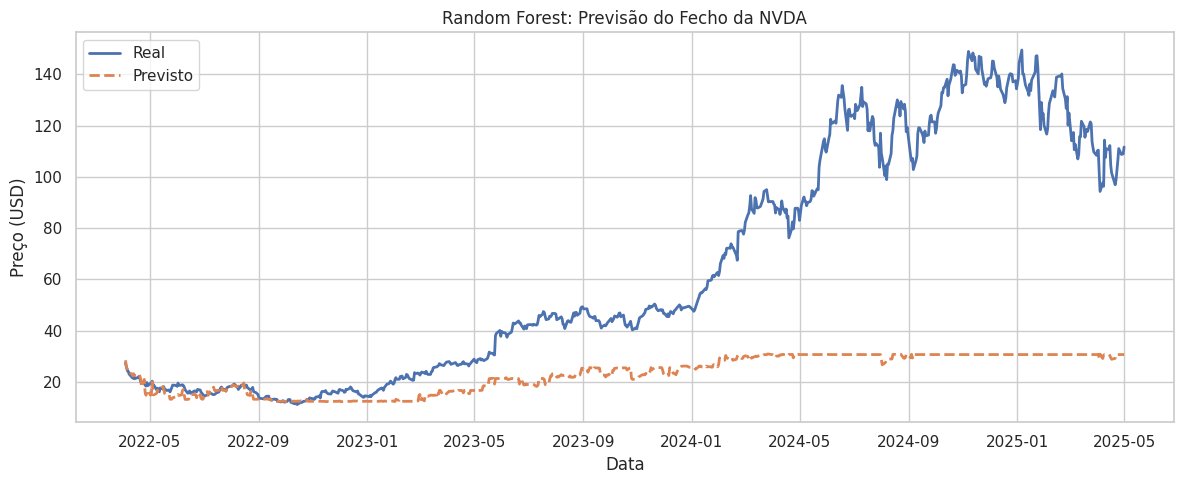

In [36]:
# Importando o RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Passo 1: Selecionar as colunas do dataset
# Aqui, estamos usando as colunas de preço de fechamento de várias empresas, por exemplo:
data = df[['Close_AAPL', 'Close_AMZN', 'Close_GOOGL', 'Close_MSFT', 'Close_NVDA']].dropna()

# Passo 2: Definir as variáveis independentes (X) e dependente (y)
# X são as variáveis de entrada (fechamento de várias ações) e y é o preço de fechamento da NVDA
X = data[['Close_AAPL', 'Close_AMZN', 'Close_GOOGL', 'Close_MSFT']]  # Features (variáveis independentes)
y = data['Close_NVDA']  # Target (variável dependente)

# Passo 3: Dividir o conjunto de dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Passo 4: Instanciar o modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Passo 5: Ajustar o modelo aos dados de treino
model_rf.fit(X_train, y_train)

# Passo 6: Fazer previsões no conjunto de teste
y_pred_rf = model_rf.predict(X_test)

# Passo 7: Avaliar o modelo
r2 = r2_score(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
print(f'R² Score: {r2:.3f}')
print(f'Mean Squared Error: {mse:.2f}')

# Passo 8: Visualizar resultados reais vs. previstos
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Real', linewidth=2)
plt.plot(y_test.index, y_pred_rf, label='Previsto', linestyle='--', linewidth=2)
plt.title('Random Forest: Previsão do Fecho da NVDA')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4: modelo de regressão Ridge

In [37]:
from sklearn.linear_model import Ridge

# Inicializar e treinar o modelo de regressão Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Fazer previsões
y_pred_ridge = model_ridge.predict(X_test)

# Avaliar modelo
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'R² Score (Ridge): {r2_ridge:.3f}')
print(f'Mean Squared Error (Ridge): {mse_ridge:.2f}')


R² Score (Ridge): -0.474
Mean Squared Error (Ridge): 3043.27


## 5: Cálculo de Retornos Acumulados e Rendimento

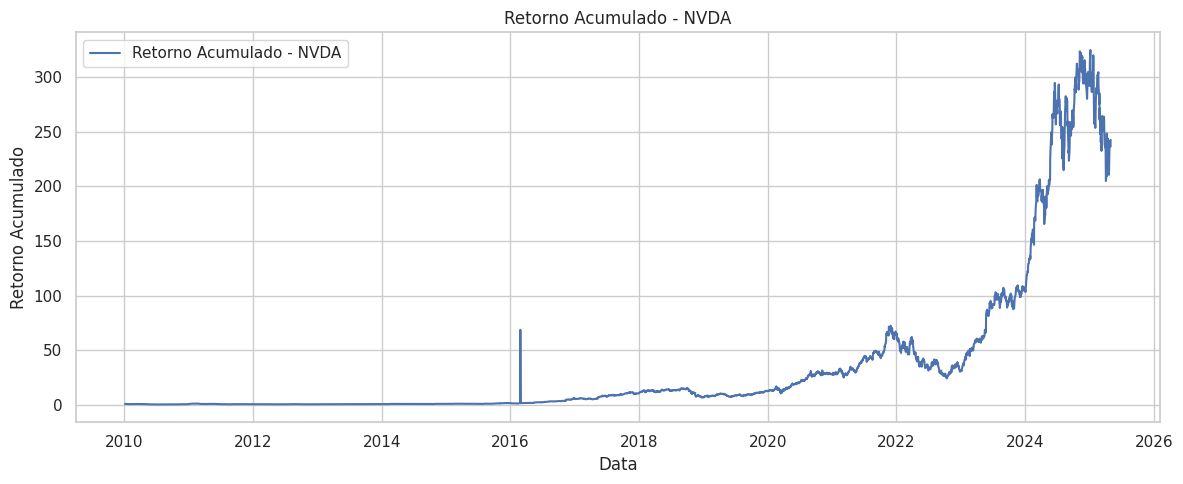

In [38]:
# Calcular o retorno acumulado
df['Return_NVDA'] = df['Close_NVDA'].pct_change()
df['Cumulative_NVDA'] = (1 + df['Return_NVDA']).cumprod()

# Plotar o retorno acumulado
plt.figure(figsize=(12, 5))
plt.plot(df['Cumulative_NVDA'], label='Retorno Acumulado - NVDA')
plt.title('Retorno Acumulado - NVDA')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Prophet – Trend & Seasonality-Aware Forecast (Google and NVDA)

21:42:41 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing


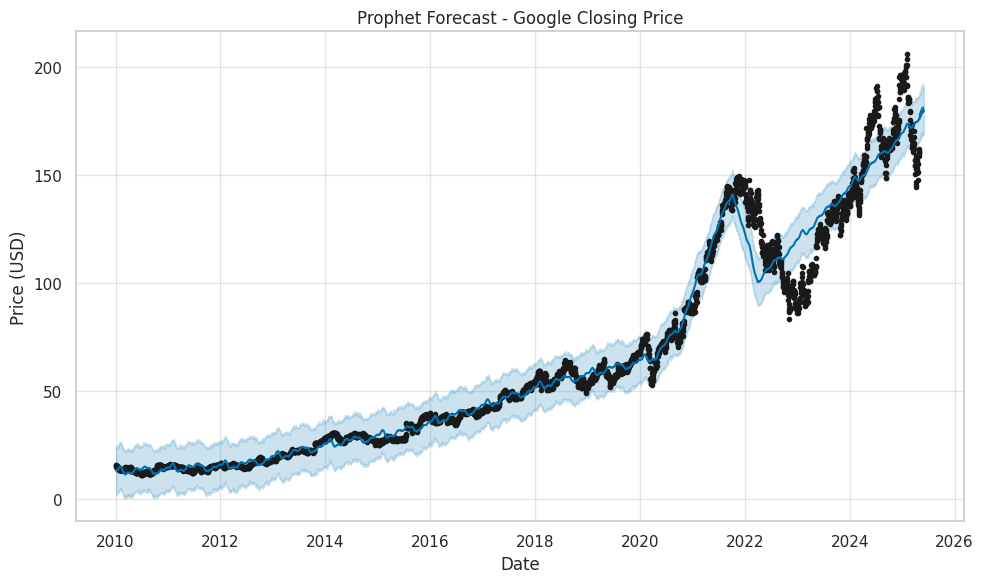

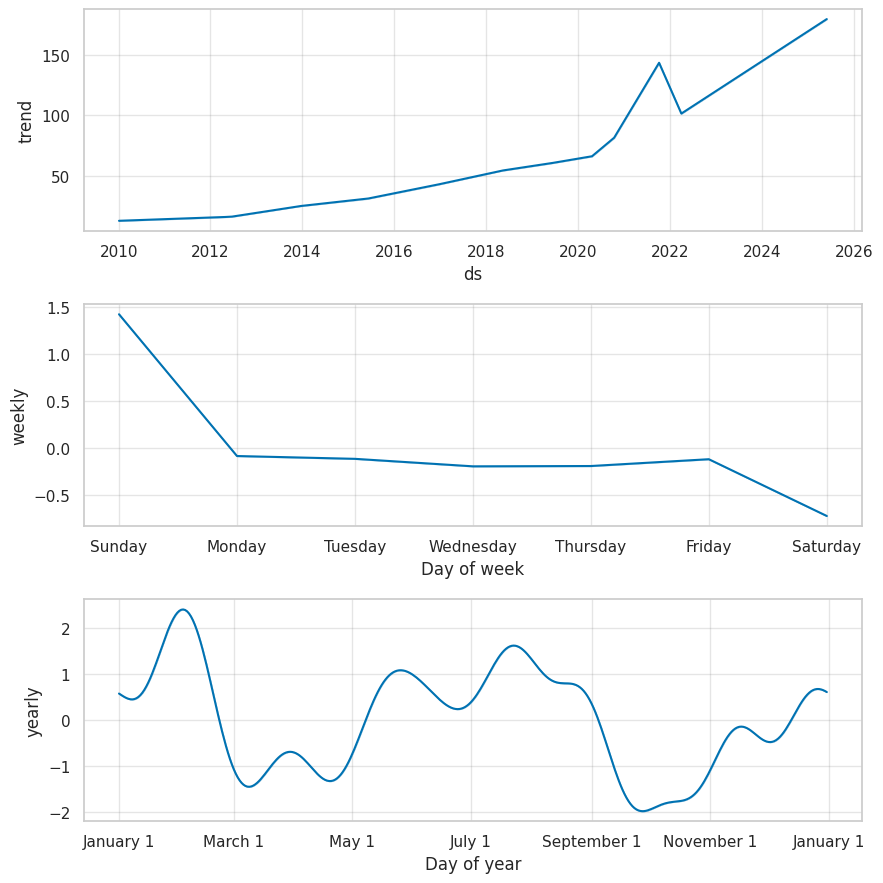

In [39]:
# --- Prophet Forecast for Google Closing Price ---
# Forecast Close_GOOGL using Facebook Prophet

from prophet import Prophet
import matplotlib.pyplot as plt

# Preparar dados no formato esperado pelo Prophet (colunas: ds, y)
df_prophet = df.reset_index()[['Date', 'Close_GOOGL']].rename(columns={'Date': 'ds', 'Close_GOOGL': 'y'}).dropna()

# Inicializar modelo Prophet com parâmetros padrão (ajustar conforme necessário)
model = Prophet()

# Ajustar modelo aos dados históricos
model.fit(df_prophet)

# Criar DataFrame para previsão futura (30 dias à frente)
future = model.make_future_dataframe(periods=30)

# Gerar previsões
forecast = model.predict(future)

# Plotar previsão com componentes
fig1 = model.plot(forecast)
plt.title("Prophet Forecast - Google Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()

# Opcional: plotar componentes da previsão (tendência, sazonalidade)
fig2 = model.plot_components(forecast)

plt.show()


21:42:59 - cmdstanpy - INFO - Chain [1] start processing
21:43:02 - cmdstanpy - INFO - Chain [1] done processing


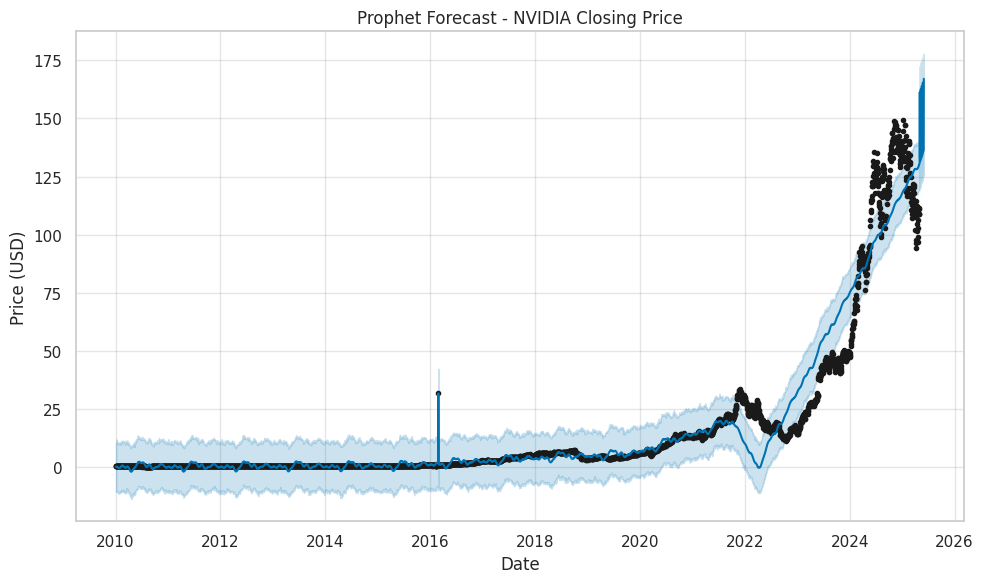

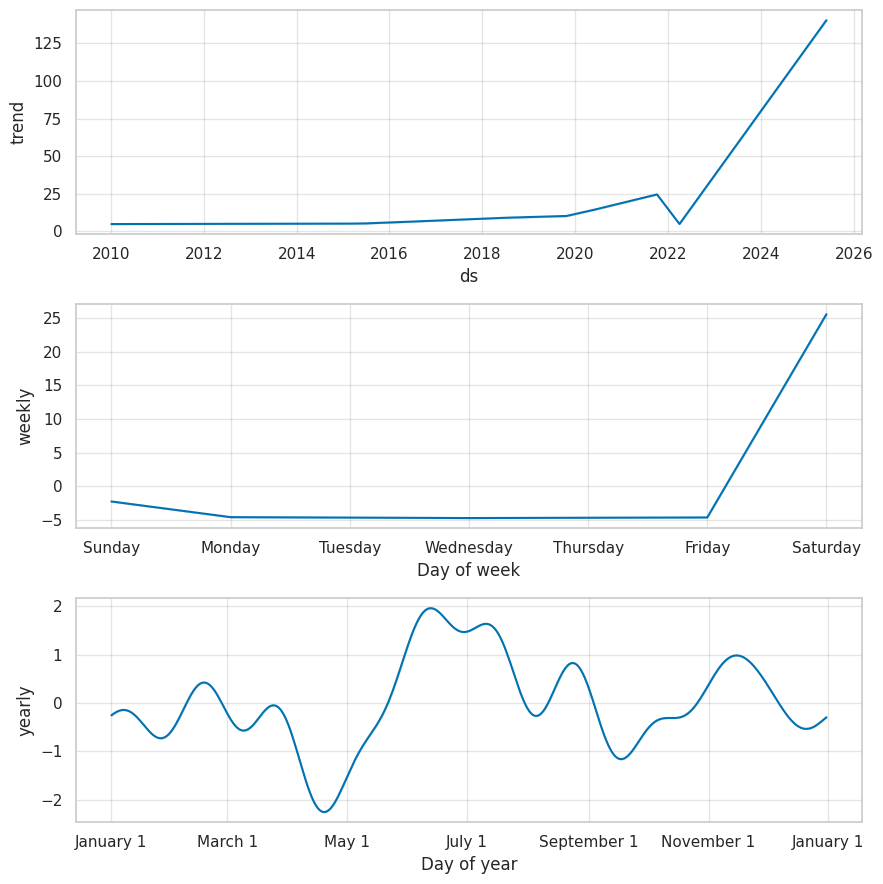

In [40]:
# --- Prophet Forecast for NVIDIA Closing Price ---
# Forecast Close_NVDA using Facebook Prophet

from prophet import Prophet
import matplotlib.pyplot as plt

# Preparar dados no formato esperado pelo Prophet (colunas: ds, y)
df_prophet = df.reset_index()[['Date', 'Close_NVDA']].rename(columns={'Date': 'ds', 'Close_NVDA': 'y'}).dropna()

# Inicializar modelo Prophet com parâmetros padrão (ajustar conforme necessário)
model = Prophet()

# Ajustar modelo aos dados históricos
model.fit(df_prophet)

# Criar DataFrame para previsão futura (30 dias à frente)
future = model.make_future_dataframe(periods=30)

# Gerar previsões
forecast = model.predict(future)

# Plotar previsão com componentes
fig1 = model.plot(forecast)
plt.title("Prophet Forecast - NVIDIA Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()

# Opcional: plotar componentes da previsão (tendência, sazonalidade)
fig2 = model.plot_components(forecast)

plt.show()


## 7. Multivariate Regression – Predict One Company Using Others (e.g., NVDA)

R² Score: -0.474
Mean Squared Error: 3043.27


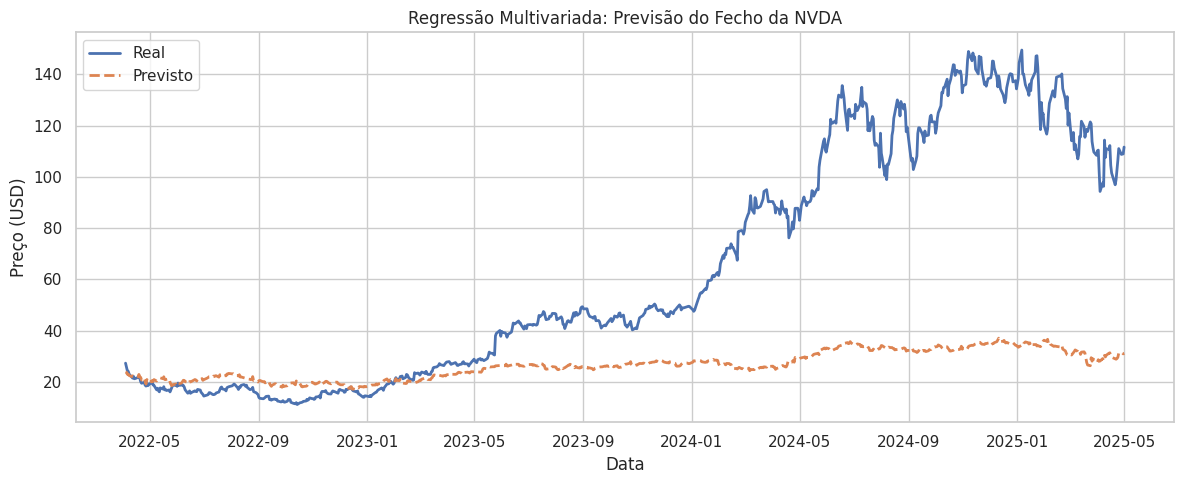

In [41]:
# --- Multivariate Regression ---
# Predict Close_NVDA using other companies' closing prices with Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Selecionar colunas relevantes e remover valores nulos
data = df[['Close_AAPL', 'Close_AMZN', 'Close_GOOGL', 'Close_MSFT', 'Close_NVDA']].dropna()

# Variáveis independentes (features) e dependente (target)
X = data[['Close_AAPL', 'Close_AMZN', 'Close_GOOGL', 'Close_MSFT']]
y = data['Close_NVDA']

# Dividir em treino e teste (20% teste), mantendo ordem temporal (sem shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Inicializar e treinar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar modelo
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R² Score: {r2:.3f}')
print(f'Mean Squared Error: {mse:.2f}')

# Visualizar resultados reais vs. previstos
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Real', linewidth=2)
plt.plot(y_test.index, y_pred, label='Previsto', linestyle='--', linewidth=2)
plt.title('Regressão Multivariada: Previsão do Fecho da NVDA')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 8. LSTM – Deep Learning Forecast for Stock Price (NVDA)

In [42]:
# --- LSTM Forecasting for Microsoft ---
# LSTM requires 3D input [samples, timesteps, features]

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Preprocessing
data = df['Close_MSFT'].dropna().values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare sequences
def create_dataset(series, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(series)):
        X.append(series[i-time_steps:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)

# Train-test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted', linestyle='--')
plt.title("LSTM Forecast - Microsoft")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'tensorflow'